<a href="https://colab.research.google.com/github/UriB1/DL---X-ray-Image-Classification/blob/main/X_ray_Classification_Training_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train NoteBook Part 1

**Description:**

Training notebook for chest XRay classifications (binary and multi).  In addition, image classification with embedding vectors using KNN and t-SNE visualization is implemented.

**Usage guide:**

- Run setup tasks
- Run data preperation tasks
- Run model tasks
- Run evaluate tasks
- Run save tasks

## Imports and Variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import shutil
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Constants for image dimensions and learning rate
IMG_HEIGHT = 250 # Previous values: 128
IMG_WIDTH = 250 # Previous values: 128
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
LEARNING_RATE = 0.00001 # Previous values: 0.1, 0.01, 0.001, 0.00001, 0.005
MULTI_LEARNING_RATE = 0.00001 # Previous values: 0.1, 0.01, 0.001, 0.00001, 0.005

# Setting n_neighbors value as the sqrt root of the size of the test set
N_NEIGHBORS = 25

Mounted at /content/drive


## Pre-Training
This part will modify the data and it's directories for a better accuracy results and order.

### Fetching Pneumonia Data Set Using API

In [ ]:
# Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

# Check if dataset is downloaded; if not, download and unzip
if not os.path.exists("chest_xray"):
  os.system("kaggle datasets download -d paultimothymooney/chest-xray-pneumonia")
  os.system("unzip chest-xray-pneumonia.zip")

### Functions
All function are suitable for our binary-class and multi class models.

#### Function to Move Images

In [ ]:
# Function to move images according to the split
def move_images_by_name(images_lists, source_directory, directory_arr, model_type):
  for filename in os.listdir(source_directory):
    source_file_path = os.path.join(source_directory, filename)
    if model_type == 0:
      if source_directory == directory_arr[0] and filename in image_lists[1]:
        destination_file_path = os.path.join(directory_arr[2], filename)
        shutil.move(source_file_path, destination_file_path)

      elif source_directory == directory_arr[1] and filename in image_lists[1]:
        destination_file_path = os.path.join(directory_arr[3], filename)
        shutil.move(source_file_path, destination_file_path)

      elif source_directory == directory_arr[2] and filename in image_lists[0]:
        destination_file_path = os.path.join(directory_arr[0], filename)
        shutil.move(source_file_path, destination_file_path)

      elif source_directory == directory_arr[3] and filename in image_lists[0]:
        destination_file_path = os.path.join(directory_arr[1], filename)
        shutil.move(source_file_path, destination_file_path)

    else:
      if source_directory == directory_arr[0] and filename in image_lists[1]:
        destination_file_path = os.path.join(directory_arr[3], filename)
        shutil.move(source_file_path, destination_file_path)

      elif source_directory == directory_arr[1] and filename in image_lists[1]:
        destination_file_path = os.path.join(directory_arr[4], filename)
        shutil.move(source_file_path, destination_file_path)

      elif source_directory == directory_arr[2] and filename in image_lists[1]:
        destination_file_path = os.path.join(directory_arr[5], filename)
        shutil.move(source_file_path, destination_file_path)

      elif source_directory == directory_arr[3] and filename in image_lists[0]:
        destination_file_path = os.path.join(directory_arr[0], filename)
        shutil.move(source_file_path, destination_file_path)

      elif source_directory == directory_arr[4] and filename in image_lists[0]:
        destination_file_path = os.path.join(directory_arr[1], filename)
        shutil.move(source_file_path, destination_file_path)

      elif source_directory == directory_arr[5] and filename in image_lists[0]:
        destination_file_path = os.path.join(directory_arr[2], filename)
        shutil.move(source_file_path, destination_file_path)

#### Function To Balance Class Amounts

In [ ]:
# Function to blind copy images according to the imbalance
def oversampling_func(minority, difference, directory_arr):
  if minority == 'NORMAL':
    while difference != 0:
      for file_name in os.listdir(directory_arr[0]):
        # Check if the required number of additional samples has been reached
        if difference == 0: break
        # Generate a new filename with an 'aug_' prefix
        new_file_name = f"aug_{difference}_{file_name}"
        shutil.copy(os.path.join(directory_arr[0], file_name), os.path.join(directory_arr[0], new_file_name))
        # Decrement the remaining required samples to copy
        difference = difference - 1

  elif minority == 'PNEUMONIA' or minority == 'BACTERIA':
    while difference != 0:
      for file_name in os.listdir(directory_arr[1]):
        if difference == 0: break
        new_file_name = f"aug_{difference}_{file_name}"
        shutil.copy(os.path.join(directory_arr[1], file_name), os.path.join(directory_arr[1], new_file_name))
        difference = difference - 1

  elif minority == 'VIRUS':
    while difference != 0:
      for file_name in os.listdir(directory_arr[2]):
        if difference == 0: break
        new_file_name = f"aug_{difference}_{file_name}"
        shutil.copy(os.path.join(directory_arr[2], file_name), os.path.join(directory_arr[2], new_file_name))
        difference = difference - 1

#### Function To Fix Image Moving After Split
The spilt makes the class amounts uneven.
A correction is needed.

In [ ]:
# Function to move images to fix split results and imbalance
def fix_image_move(fix_move, source_directory, destination_directory):
    for filename in os.listdir(source_directory):
        if fix_move > 0:
            source_file_path = os.path.join(source_directory, filename)
            destination_file_path = os.path.join(destination_directory, filename)
            shutil.move(source_file_path, destination_file_path)
            fix_move = fix_move - 1
        else:
            break  # Exit the loop if fix_move is no longer greater than 0

#### Function To Reorganize Directories
Needed only in the multi-class model.

In [ ]:
# Function to create new directories within the data set and move images according to virus/bacteria
def dir_reOrganize_func(source_directory, destination_directory, string_to_match):
    # Create the destination subdirectory
    subdirectory_path = os.path.join(destination_directory, string_to_match.upper())
    os.makedirs(subdirectory_path, exist_ok=True)

    for filename in os.listdir(source_directory):
        source_file_path = os.path.join(source_directory, filename)

        if string_to_match in filename:
            destination_file_path = os.path.join(subdirectory_path, filename)
            shutil.move(source_file_path, destination_file_path)

#### Function To Find Best n_neighbors Value
Allows us to check which n_neighbors value is best for the use of KNN during the second part of the project.

In [ ]:
# A function to find the best n_neighbors value
def find_best_n_neighbors(embedding_vectors_train, train_labels, embedding_vectors_test, test_labels):
    best_accuracy = 0
    best_n_neighbors = 0

    # Define a range of odd n_neighbors values from 1 to 100
    n_values = np.arange(1, 101, step=2)

    for n in n_values:
        knn_classifier = KNeighborsClassifier(n_neighbors=n)
        knn_classifier.fit(embedding_vectors_train, train_labels)

        # Evaluate the model on the test set
        accuracy = knn_classifier.score(embedding_vectors_test, test_labels)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = n

    return best_n_neighbors, best_accuracy

### Binary Imbalance Check
For better model results we should check if there is imbalance between the classes. If it does, we'll use over-sampling (bilnd copy) as a method to solve it.

In [ ]:
# Set the paths for training, val, and test sets
train_dir = '/content/chest_xray/train'
train_dir_n = '/content/chest_xray/train/NORMAL'
train_dir_p = '/content/chest_xray/train/PNEUMONIA'

val_dir = '/content/chest_xray/val'
val_dir_n = '/content/chest_xray/val/NORMAL'
val_dir_p = '/content/chest_xray/val/PNEUMONIA'

test_dir = '/content/chest_xray/test'
test_dir_n = '/content/chest_xray/test/NORMAL'
test_dir_p = '/content/chest_xray/test/PNEUMONIA'

directories = [train_dir_n, train_dir_p, val_dir_n, val_dir_p, test_dir_n, test_dir_p]

In [ ]:
# The number of images in each class
num_binary_normal_images = len(os.listdir(directories[0])) + len(os.listdir(directories[2]))
num_binary_pneumonia_images = len(os.listdir(directories[1])) + len(os.listdir(directories[3]))

minority = 'none'
difference = 0

# Checking imbalance between binary classes
if num_binary_normal_images < num_binary_pneumonia_images:
  minority = 'NORMAL'
  print('Imbalance found! More NORMAL images are required.')
elif num_binary_normal_images > num_binary_pneumonia_images:
  minority = 'PNEUMONIA'
  print('Imbalance found! More PNEUMONIA images are required.')
else:
  print('The classes are balanced.')

if minority != 'none':
  if minority == 'NORMAL':
    difference = num_binary_pneumonia_images - num_binary_normal_images
  else:
    difference = num_binary_normal_images - num_binary_pneumonia_images

print('NORMAL class counter:', num_binary_normal_images)
print('PNEUMONIA class counter:', num_binary_pneumonia_images)
print('Difference:', difference)

Imbalance found! More NORMAL images are required.
NORMAL class counter: 1349
PNEUMONIA class counter: 3883
Difference: 2534


In [ ]:
# Blind copy to balance classes
oversampling_func(minority, difference, directories)

# The new number of images in each class
new_num_binary_normal_images = len(os.listdir(directories[0])) + len(os.listdir(directories[2]))
new_num_binary_pneumonia_images = len(os.listdir(directories[1])) + len(os.listdir(directories[3]))

print('NORMAL class counter:', new_num_binary_normal_images)
print('PNEUMONIA class counter:', new_num_binary_pneumonia_images)

NORMAL class counter: 3883
PNEUMONIA class counter: 3883


### Binary Spliting
The spliting of the data set is for a better division between the train set and the val set, which will lead to better training results.

Since we were given 2 copies of the data set within the directories, we'll use each copy for a different model (binary-class and multi-class).
Therefore we'll split the data set twice - Each split in a separate directory. This is the first split.

In [ ]:
# Creating and combining lists of the filenames of the train and val images
original_train_images_n, original_train_images_p = [f for f in os.listdir(directories[0]) if os.path.isfile(os.path.join(directories[0], f))], [f for f in os.listdir(directories[1]) if os.path.isfile(os.path.join(directories[1], f))]
original_val_images_n, original_val_images_p = [f for f in os.listdir(directories[2]) if os.path.isfile(os.path.join(directories[2], f))], [f for f in os.listdir(directories[3]) if os.path.isfile(os.path.join(directories[3], f))]

original_train_images = original_train_images_n + original_train_images_p
original_val_images = original_val_images_n + original_val_images_p
combined_images = original_train_images + original_val_images

In [ ]:
# Split the data into training and validation sets
# Previous split percentge: 0.25
new_train_images, new_val_images = train_test_split(combined_images, test_size=0.2, random_state=42)

#Showing new lists sizes
len(new_train_images), len(new_val_images)

(6212, 1554)

In [ ]:
# Moving all required images
image_lists = [new_train_images, new_val_images]

move_images_by_name(image_lists, directories[0], directories, 0)
move_images_by_name(image_lists, directories[1], directories, 0)
move_images_by_name(image_lists, directories[2], directories, 0)
move_images_by_name(image_lists, directories[3], directories, 0)

In [ ]:
# Image lists lengths in directories
len(os.listdir(directories[0])), len(os.listdir(directories[1])), len(os.listdir(directories[2])), len(os.listdir(directories[3]))

(3115, 3097, 768, 786)

In [ ]:
# fixing all required image movements
fix_moving1 = (len(os.listdir(directories[0])) - len(os.listdir(directories[1]))) / 2
fix_moving2 = (len(os.listdir(directories[3])) - len(os.listdir(directories[2]))) / 2

fix_image_move(fix_moving1, directories[0], directories[2])
fix_image_move(fix_moving2, directories[3], directories[1])

In [ ]:
# Updated image lists lengths in directories
len(os.listdir(directories[0])), len(os.listdir(directories[1])), len(os.listdir(directories[2])), len(os.listdir(directories[3]))

(3106, 3106, 777, 777)

### Reorganizing Images For Multi-class
Since we were given 2 copies of the data set within the directories, we'll use each copy for a different model (binary-class and multi-class). Therefore we'll change the directories of the multi-class model for a better label division.

In [ ]:
# Set the paths for training, val, and test sets
multi_train_dir = '/content/chest_xray/chest_xray/train'
multi_train_dir_n = '/content/chest_xray/chest_xray/train/NORMAL'
multi_train_dir_p = '/content/chest_xray/chest_xray/train/PNEUMONIA'

multi_val_dir = '/content/chest_xray/chest_xray/val'
multi_val_dir_n = '/content/chest_xray/chest_xray/val/NORMAL'
multi_val_dir_p = '/content/chest_xray/chest_xray/val/PNEUMONIA'

multi_test_dir = '/content/chest_xray/chest_xray/test'
multi_test_dir_n = '/content/chest_xray/chest_xray/test/NORMAL'
multi_test_dir_p = '/content/chest_xray/chest_xray/test/PNEUMONIA'

In [ ]:
# Updating categories for a simple assignment of labels
dir_reOrganize_func(multi_train_dir_p, multi_train_dir, 'virus')
dir_reOrganize_func(multi_train_dir_p, multi_train_dir, 'bacteria')

dir_reOrganize_func(multi_val_dir_p, multi_val_dir, 'virus')
dir_reOrganize_func(multi_val_dir_p, multi_val_dir, 'bacteria')

dir_reOrganize_func(multi_test_dir_p, multi_test_dir, 'virus')
dir_reOrganize_func(multi_test_dir_p, multi_test_dir, 'bacteria')

In [ ]:
# Deleting all empty folders after updates
folders_to_delete = [multi_train_dir_p, multi_val_dir_p, multi_test_dir_p]

for folder in folders_to_delete:
  try:
    shutil.rmtree(folder)
    print(f"Folder '{folder}' and its contents deleted successfully.")
  except Exception as e:
    print(f"Error deleting folder '{folder}': {e}")

Folder '/content/chest_xray/chest_xray/train/PNEUMONIA' and its contents deleted successfully.
Folder '/content/chest_xray/chest_xray/val/PNEUMONIA' and its contents deleted successfully.
Folder '/content/chest_xray/chest_xray/test/PNEUMONIA' and its contents deleted successfully.


In [ ]:
# Set the new created paths for training, val, and test sets

multi_train_dir_b = '/content/chest_xray/chest_xray/train/BACTERIA'
multi_train_dir_v = '/content/chest_xray/chest_xray/train/VIRUS'

multi_val_dir_b = '/content/chest_xray/chest_xray/val/BACTERIA'
multi_val_dir_v = '/content/chest_xray/chest_xray/val/VIRUS'

multi_test_dir_b = '/content/chest_xray/chest_xray/test/BACTERIA'
multi_test_dir_v = '/content/chest_xray/chest_xray/test/VIRUS'

multi_directories = [multi_train_dir_n, multi_train_dir_b, multi_train_dir_v, multi_val_dir_n, multi_val_dir_b, multi_val_dir_v, multi_test_dir_n, multi_test_dir_b, multi_test_dir_v]

### Multi Imbalance Check
For better model results we should check if there is imbalance between the classes. If it does, we'll use over-sampling (bilnd copy) as a method to solve it.

In [ ]:
# The number of images in each class
num_multi_normal_images = len(os.listdir(multi_directories[0])) + len(os.listdir(multi_directories[3]))
num_multi_bacteria_images = len(os.listdir(multi_directories[1])) + len(os.listdir(multi_directories[4]))
num_multi_virus_images = len(os.listdir(multi_directories[2])) + len(os.listdir(multi_directories[5]))

minority1 = 'none'
minority2 = 'none'
difference1 = 0
difference2 = 0

# Checking imbalance between binary classes
if num_multi_normal_images == max(num_multi_normal_images, num_multi_bacteria_images, num_multi_virus_images):
  difference1 = num_multi_normal_images - num_multi_bacteria_images
  difference2 = num_multi_normal_images - num_multi_virus_images
  if difference1 != 0 or difference2 != 0:
    minority1 = 'BACTERIA'
    minority2 = 'VIRUS'
    print('Imbalance found! NORMAL class is the majority group.')

elif num_multi_bacteria_images == max(num_multi_normal_images, num_multi_bacteria_images, num_multi_virus_images):
  difference1 = num_multi_bacteria_images - num_multi_normal_images
  difference2 = num_multi_bacteria_images - num_multi_virus_images
  if difference1 != 0 or difference2 != 0:
    minority1 = 'NORMAL'
    minority2 = 'VIRUS'
    print('Imbalance found! BACTERIA class is the majority group.')

elif num_multi_virus_images == max(num_multi_normal_images, num_multi_bacteria_images, num_multi_virus_images):
  difference1 = num_multi_virus_images - num_multi_bacteria_images
  difference2 = num_multi_virus_images - num_multi_normal_images
  if difference1 != 0 or difference2 != 0:
    minority1 = 'BACTERIA'
    minority2 = 'NORMAL'
    print('Imbalance found! VIRUS class is the majority group.')

if difference1 == 0 and difference2 == 0:
  print('The classes are balanced.')

print('NORMAL class counter:', num_multi_normal_images)
print('BACTERIA class counter:', num_multi_bacteria_images)
print('VIRUS class counter:', num_multi_virus_images)

Imbalance found! BACTERIA class is the majority group.
NORMAL class counter: 1351
BACTERIA class counter: 2538
VIRUS class counter: 1345


In [ ]:
# Blind copy to balance classes
oversampling_func(minority1, difference1, multi_directories)
oversampling_func(minority2, difference2, multi_directories)

# The new number of images in each class
new_num_multi_normal_images = len(os.listdir(multi_directories[0])) + len(os.listdir(multi_directories[3]))
new_num_multi_bacteria_images = len(os.listdir(multi_directories[1])) + len(os.listdir(multi_directories[4]))
new_num_multi_virus_images = len(os.listdir(multi_directories[2])) + len(os.listdir(multi_directories[5]))

print('NORMAL class counter:', new_num_multi_normal_images)
print('BACTERIA class counter:', new_num_multi_bacteria_images)
print('VIRUS class counter:', new_num_multi_virus_images)

NORMAL class counter: 2538
BACTERIA class counter: 2538
VIRUS class counter: 2538


### Multi Spliting
The spliting of the data set is for a better division between the train set and the val set, which will lead to better training results.

Since we were given 2 copies of the data set within the directories, we'll use each copy for a different model (binary-class and multi-class).
Therefore we'll split the data set twice - Each split in a separate directory. This is the second split.

In [ ]:
# Creating and combining lists of the filenames of the train and val images
multi_original_train_images_n, multi_original_train_images_b, multi_original_train_images_v = [f for f in os.listdir(multi_directories[0]) if os.path.isfile(os.path.join(multi_directories[0], f))], [f for f in os.listdir(multi_directories[1]) if os.path.isfile(os.path.join(multi_directories[1], f))], [f for f in os.listdir(multi_directories[2]) if os.path.isfile(os.path.join(multi_directories[2], f))]
multi_original_val_images_n, multi_original_val_images_b, multi_original_val_images_v = [f for f in os.listdir(multi_directories[3]) if os.path.isfile(os.path.join(multi_directories[3], f))], [f for f in os.listdir(multi_directories[4]) if os.path.isfile(os.path.join(multi_directories[4], f))], [f for f in os.listdir(multi_directories[5]) if os.path.isfile(os.path.join(multi_directories[5], f))]

multi_original_train_images = multi_original_train_images_n + multi_original_train_images_b + multi_original_train_images_v
multi_original_val_images = multi_original_val_images_n + multi_original_val_images_b + multi_original_val_images_v
multi_combined_images = multi_original_train_images + multi_original_val_images

In [ ]:
# Split the data into training and validation sets
# Previous split percentge: 0.25
multi_new_train_images, multi_new_val_images = train_test_split(multi_combined_images, test_size=0.2, random_state=42)

#Showing new lists sizes
len(multi_new_train_images), len(multi_new_val_images)

(6091, 1523)

In [ ]:
# Moving all required images
multi_image_lists = [multi_new_train_images, multi_new_val_images]

move_images_by_name(multi_image_lists, multi_directories[0], multi_directories, 1)
move_images_by_name(multi_image_lists, multi_directories[1], multi_directories, 1)
move_images_by_name(multi_image_lists, multi_directories[2], multi_directories, 1)
move_images_by_name(multi_image_lists, multi_directories[3], multi_directories, 1)
move_images_by_name(multi_image_lists, multi_directories[4], multi_directories, 1)
move_images_by_name(multi_image_lists, multi_directories[5], multi_directories, 1)

In [ ]:
# Image lists lengths in directories
len(os.listdir(multi_directories[0])), len(os.listdir(multi_directories[1])), len(os.listdir(multi_directories[2])), len(os.listdir(multi_directories[3])), len(os.listdir(multi_directories[4])), len(os.listdir(multi_directories[5]))

(2282, 2030, 2260, 256, 508, 278)

In [ ]:
# fixing all required images movements
class_desired_num_t = len(multi_new_train_images) / 3

if class_desired_num_t > len(os.listdir(multi_directories[0])):
  multi_fix_moving1 = class_desired_num_t - len(os.listdir(multi_directories[0]))
  fix_image_move(multi_fix_moving1, multi_directories[3], multi_directories[0])
else:
  multi_fix_moving1 = len(os.listdir(multi_directories[0])) - class_desired_num_t
  fix_image_move(multi_fix_moving1, multi_directories[0], multi_directories[3])

if class_desired_num_t > len(os.listdir(multi_directories[1])):
  multi_fix_moving1 = class_desired_num_t - len(os.listdir(multi_directories[1]))
  fix_image_move(multi_fix_moving1, multi_directories[4], multi_directories[1])
else:
  multi_fix_moving1 = len(os.listdir(multi_directories[1])) - class_desired_num_t
  fix_image_move(multi_fix_moving1, multi_directories[1], multi_directories[4])

if class_desired_num_t > len(os.listdir(multi_directories[2])):
  multi_fix_moving1 = class_desired_num_t - len(os.listdir(multi_directories[2]))
  fix_image_move(multi_fix_moving1, multi_directories[5], multi_directories[2])
else:
  multi_fix_moving1 = len(os.listdir(multi_directories[2])) - class_desired_num_t
  fix_image_move(multi_fix_moving1, multi_directories[2], multi_directories[5])

In [ ]:
# Updated image lists lengths in directories.
len(os.listdir(multi_directories[0])), len(os.listdir(multi_directories[1])), len(os.listdir(multi_directories[2])), len(os.listdir(multi_directories[3])), len(os.listdir(multi_directories[4])), len(os.listdir(multi_directories[5]))

(2030, 2031, 2030, 508, 507, 508)

## Binary-Class Classification

### Create instances of ImageDataGenerator


In [ ]:
BATCH_SIZE = 16

# Instance of ImageDataGenerator for training data
# We tried two types of train datagens and used the one with the augmentation

#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15, # Previous values: 20, 30, 40, 50, 60
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.15, # Previous values: 0.2
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Instance of ImageDataGenerator for val data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Instance of ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 6212 images belonging to 2 classes.
Found 1554 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model Creation

#### Previous Model Attemps

In [ ]:
# Examples of previous attempts

model = Sequential([
    Conv2D(32, kernel_size=(3,3), padding="same", activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D(),
    Conv2D(16, kernel_size=(3,3), padding="same", activation='relu'),
    MaxPooling2D(),
    Conv2D(16, kernel_size=(3,3), padding="same", activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu', name='embedding_layer'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Previous values for conv2D layers are 16,32,64,128
# Previous values for Dense layers are 64, 128, 256, 512
# Previous values for Dropout are 0.2, 0.3, 0.4, 0.1
# There was an attempt of 4 conv2D layers instead of 3.
# There was an attempt of adding the dropout after every layer and another attempt of adding it after every second layer.


# Added batch normalization, added l2 regularizer, removed dropout
model = Sequential([
    Conv2D(32, kernel_size=(3,3), padding="same", activation='relu', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(16, kernel_size=(3,3), padding="same", activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(16, kernel_size=(3,3), padding="same", activation='relu', name='embedding_layer'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dense(1, activation='sigmoid')
])

# Previous values for conv2D layers are 16,32,64,128
# Previous values for Dense layers are 64, 128, 256, 512

# Removed batch normalization and l2 regularizers.
# Added more Conv2D layers (different number of filters) and MaxPooling layers accordingly.
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= INPUT_SHAPE),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu", name='embedding_layer'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(1, activation = "sigmoid")
])

# Previous values for conv2D layers are 16,32,64,128
# Previous values for Dense layers are 64, 128, 256, 512

#### Current Model

In [ ]:
# Define the CNN model

# Different number of filters. Added dropout after dense layers. Added another dense layer.
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= INPUT_SHAPE),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='embedding_layer'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128,activation = "relu"),
    Dropout(0.2),
    Dense(128,activation = "relu"),
    Dropout(0.2),
    Dense(128,activation = "relu"),
    Dropout(0.2),
    Dense(1, activation = "sigmoid")
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 125, 125, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 62, 62, 128)      

In [ ]:
# Extract the embedding layer
embedding_model = Model(inputs=model.input, outputs=model.get_layer('embedding_layer').output)

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train the model
history = model.fit(train_generator, batch_size=BATCH_SIZE, epochs=10, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/10
389/389 [==============================] - 202s 505ms/step - loss: 0.6404 - accuracy: 0.6151 - val_loss: 0.3255 - val_accuracy: 0.8790
Epoch 2/10
389/389 [==============================] - 201s 518ms/step - loss: 0.3190 - accuracy: 0.8764 - val_loss: 0.2548 - val_accuracy: 0.9015
Epoch 3/10
389/389 [==============================] - 199s 512ms/step - loss: 0.2446 - accuracy: 0.9123 - val_loss: 0.1535 - val_accuracy: 0.9427
Epoch 4/10
389/389 [==============================] - 199s 511ms/step - loss: 0.2238 - accuracy: 0.9181 - val_loss: 0.1584 - val_accuracy: 0.9453
Epoch 5/10
389/389 [==============================] - 196s 504ms/step - loss: 0.2048 - accuracy: 0.9297 - val_loss: 0.1382 - val_accuracy: 0.9485
Epoch 6/10
389/389 [==============================] - 198s 508ms/step - loss: 0.1902 - accuracy: 0.9301 - val_loss: 0.1270 - val_accuracy: 0.9601
Epoch 7/10
389/389 [==============================] - 198s 508ms/step - loss: 0.1855 - accuracy: 0.9303 - val_loss: 0.1268 -

#### Model Graphs

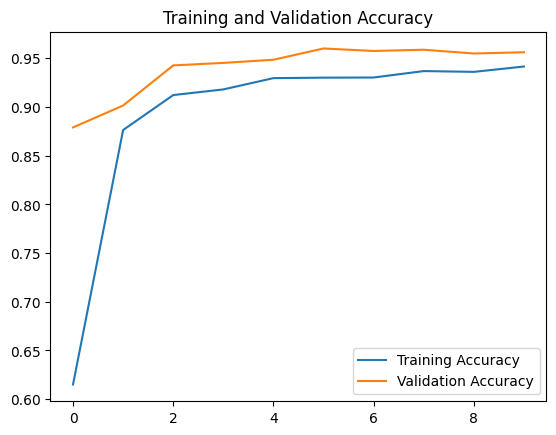

In [ ]:
# Plot training and validation accuracy
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

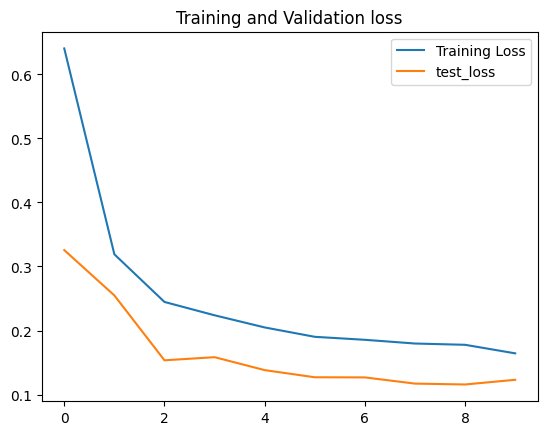

In [ ]:
# Plot training and validation loss
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'],label = 'test_loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### Model - Accuracy and Save

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_accuracy}', f'Test Loss: {test_loss}')

39/39 [==============================] - 6s 163ms/step - loss: 0.3149 - accuracy: 0.9006
Test Accuracy: 0.9006410241127014 Test Loss: 0.31490617990493774


In [ ]:
model.save("/content/drive/MyDrive/my_models/basics_in_deep_learning/binary_class_part1.keras")
np.save("/content/drive/MyDrive/my_models/basics_in_deep_learning/binary_training_history.npy", history.history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 6s 155ms/step


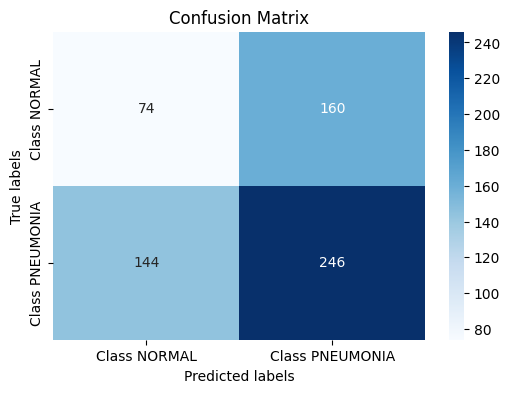

              precision    recall  f1-score   support

           0       0.34      0.32      0.33       234
           1       0.61      0.63      0.62       390

    accuracy                           0.51       624
   macro avg       0.47      0.47      0.47       624
weighted avg       0.51      0.51      0.51       624



In [ ]:
y_true = test_generator.labels
y_pred_probabilities = model.predict(test_generator)
y_pred = (y_pred_probabilities > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class NORMAL', 'Class PNEUMONIA'], yticklabels=['Class NORMAL', 'Class PNEUMONIA'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

### New Image Classification Using Embedded Vector  

In [ ]:
# Extract embedding vectors for training and testing data
embedding_vectors_train = embedding_model.predict(train_generator)
embedding_vectors_test = embedding_model.predict(test_generator)

embedding_vectors_train_flat = embedding_vectors_train.reshape(embedding_vectors_train.shape[0], -1)
embedding_vectors_test_flat = embedding_vectors_test.reshape(embedding_vectors_test.shape[0], -1)

#Find best n_neighbors value
#best_n, best_accuracy = find_best_n_neighbors(embedding_vectors_train, train_generator.labels, embedding_vectors_test, test_generator.labels)
#print('The best n_neighbors value is', best_n, 'with an accuracy of', best_accuracy)

39/39 [==============================] - 6s 148ms/step


In [ ]:
# Use KNN for classification
knn_classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
knn_classifier.fit(embedding_vectors_train_flat, train_generator.labels)

KNeighborsClassifier(n_neighbors=25)

In [ ]:
# Saving the embedding vectors for training and testing data to Google Drive
np.save('/content/drive/MyDrive/my_models/basics_in_deep_learning/my_embedding_vectors/binary_EV_train_part1.npy', embedding_vectors_train_flat)
np.save('/content/drive/MyDrive/my_models/basics_in_deep_learning/my_embedding_vectors/binary_EV_test_part1.npy', embedding_vectors_test_flat)

# Saving the labels to a file
train_labels = train_generator.classes
np.save('/content/drive/MyDrive/my_models/basics_in_deep_learning/my_labels/binary_train_labels_part1.npy', train_labels)

test_labels = test_generator.classes
np.save('/content/drive/MyDrive/my_models/basics_in_deep_learning/my_labels/binary_test_labels_part1.npy', test_labels)

In [ ]:
# Example of classifying a new image
new_image_path = '/content/IM-0001-0001.jpeg'
new_image = cv.imread(new_image_path)
new_image = cv.resize(new_image, (IMG_HEIGHT, IMG_WIDTH))
new_image = new_image.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3) / 255.0

In [ ]:
# Extract the embedding vector for the new image
embedding_vector_new = embedding_model.predict(new_image)
embedding_vector_new_flat = embedding_vector_new.reshape(embedding_vector_new.shape[0], -1)

# Classify the new image using KNN
predicted_class = knn_classifier.predict(embedding_vector_new_flat)
if predicted_class == 1:
  print(f"Predicted class for the new image is pneumonia.")
elif predicted_class == 0:
  print(f"Predicted class for the new image is normal.")

1/1 [==============================] - 0s 477ms/step
Predicted class for the new image is pneumonia.


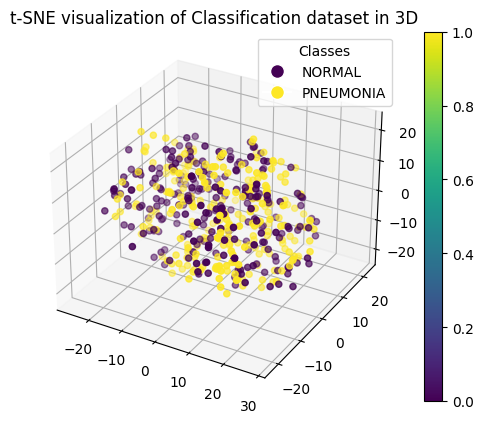

In [ ]:
# Visualize different classes using t-SNE in 3D
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(embedding_vectors_train_flat)

labels = train_generator.labels

# Subset of data points
subset_indices = np.random.choice(len(tsne_result), size=500, replace=False)

# Create a 3D scatter plot using the selected subset of data points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(xs=tsne_result[subset_indices, 0], ys=tsne_result[subset_indices, 1],
                     zs=tsne_result[subset_indices, 2], c=labels[subset_indices], cmap='viridis')

# Add color bar
cbar = plt.colorbar(scatter)

# Create legend
classes = list(set(labels))
class_names = {
    0: 'NORMAL',
    1: 'PNEUMONIA',
}

legend_labels = []
for cls in classes:
    legend_labels.append(plt.Line2D([0], [0], marker='o', color='w', label=class_names[cls],
                                     markerfacecolor=scatter.to_rgba(cls), markersize=10))

plt.legend(handles=legend_labels, title='Classes', loc='upper right')
plt.title("t-SNE visualization of Classification dataset in 3D")
plt.show()


## Multi-Class Classification

### Create instances of ImageDataGenerator


In [ ]:
MULTI_BATCH_SIZE = 16

# Instance of ImageDataGenerator for training data
# We tried two types of train datagens and used the one with the augmentation

#multi_train_datagen = ImageDataGenerator(rescale=1./255)
multi_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15, # Previous values: 20, 30, 40, 50, 60
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.15, # Previous values: 0.2
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

multi_train_generator = multi_train_datagen.flow_from_directory(
    multi_train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=MULTI_BATCH_SIZE,
    class_mode='categorical'
)

# Instance of ImageDataGenerator for val data
multi_val_datagen = ImageDataGenerator(rescale=1./255)
multi_val_generator = multi_val_datagen.flow_from_directory(
    multi_val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=MULTI_BATCH_SIZE,
    class_mode='categorical'
)

# Instance of ImageDataGenerator for test data
multi_test_datagen = ImageDataGenerator(rescale=1./255)
multi_test_generator = multi_test_datagen.flow_from_directory(
    multi_test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=MULTI_BATCH_SIZE,
    class_mode='categorical'
)

Found 4185 images belonging to 3 classes.
Found 1047 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


### Model Creation

#### Previous Attempts

In [ ]:
NUM_CLASSES = 3

# Examples of previous attempts

multi_model = Sequential([
    Conv2D(32, 3, input_shape=INPUT_SHAPE, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu', name='embedding_layer'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Previous values for conv2D layers are 16,32,64,128
# Previous values for Dense layers are 64, 128, 256, 512
# Previous values for Dropout are 0.2, 0.3, 0.4, 0.1, 0.5
# There was an attempt of 4 conv2D layers instead of 3.
# There was an attempt of adding the dropout after every layer and another attempt of adding it after every second layer.

# Added batch normalization, added l2 regularizer, removed dropout, increased complexity in dense layers
multi_model = Sequential([
    Conv2D(32, 3, input_shape=INPUT_SHAPE, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(16, 3, activation='relu', name='embedding_layer'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Previous values for conv2D layers are 16,32,64,128
# Previous values for Dense layers are 64, 128, 256, 512

# Removed batch normalization and l2 regularizers.
# Added more Conv2D layers (different number of filters) and MaxPooling layers accordingly. Added dropout after danse layers
multi_model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= INPUT_SHAPE),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='embedding_layer'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128,activation = "relu"),
    Dropout(0.2),
    Dense(128,activation = "relu"),
    Dropout(0.2),
    Dense(128,activation = "relu"),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation = "softmax")
])

# Previous values for conv2D layers are 16,32,64,128
# Previous values for Dense layers are 64, 128, 256, 512
# Previous values for Dropout are 0.2, 0.3, 0.4, 0.1, 0.5

#### Current Model

In [ ]:
# Define the CNN model for multi-class classification
NUM_CLASSES = 3

# Removed dropouts and a dense layer
multi_model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= INPUT_SHAPE),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu", name='embedding_layer'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128,activation = "relu"),
    Dense(32,activation = "relu"),
    Dense(NUM_CLASSES, activation='softmax')
])

multi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 128)       1

In [ ]:
# Extract the embedding layer
embedding_multi_model = Model(inputs=multi_model.input, outputs=multi_model.get_layer('embedding_layer').output)

In [ ]:
# Compile the model
multi_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=MULTI_LEARNING_RATE),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

# Train the model
multi_history = multi_model.fit(multi_train_generator, batch_size=16, epochs=10, validation_data=multi_val_generator, callbacks=[early_stopping])

Epoch 1/10
381/381 [==============================] - 202s 502ms/step - loss: 1.0345 - accuracy: 0.4736 - val_loss: 0.7687 - val_accuracy: 0.6485
Epoch 2/10
381/381 [==============================] - 178s 467ms/step - loss: 0.7124 - accuracy: 0.6783 - val_loss: 0.7125 - val_accuracy: 0.6459
Epoch 3/10
381/381 [==============================] - 198s 520ms/step - loss: 0.6391 - accuracy: 0.7013 - val_loss: 0.5922 - val_accuracy: 0.7523
Epoch 4/10
381/381 [==============================] - 184s 482ms/step - loss: 0.6079 - accuracy: 0.7246 - val_loss: 0.5572 - val_accuracy: 0.7424
Epoch 5/10
381/381 [==============================] - 176s 462ms/step - loss: 0.6014 - accuracy: 0.7208 - val_loss: 0.5984 - val_accuracy: 0.7411
Epoch 6/10
381/381 [==============================] - 176s 461ms/step - loss: 0.5817 - accuracy: 0.7387 - val_loss: 0.5219 - val_accuracy: 0.7740
Epoch 7/10
381/381 [==============================] - 178s 468ms/step - loss: 0.5679 - accuracy: 0.7408 - val_loss: 0.5221 -

#### Model Graphs

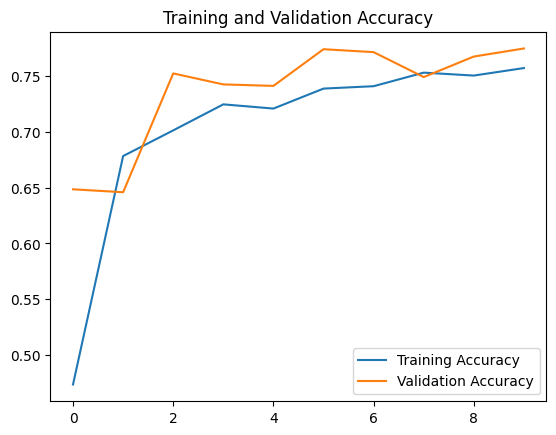

In [ ]:
# Plot training and validation accuracy
plt.plot(multi_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(multi_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

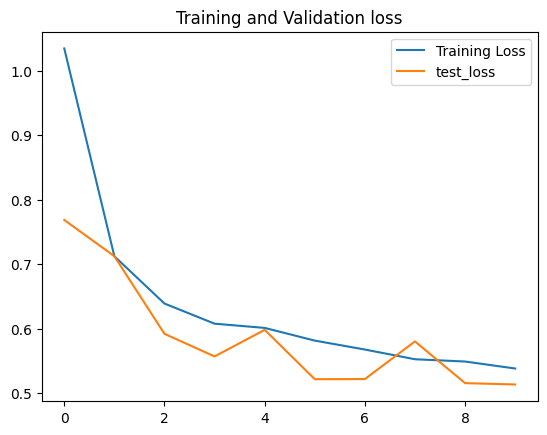

In [ ]:
# Plot training and validation loss
plt.plot(multi_model.history.history['loss'], label='Training Loss')
plt.plot(multi_model.history.history['val_loss'],label = 'test_loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#### Model - Accuracy and Save

In [ ]:
multi_test_loss, multi_test_accuracy = multi_model.evaluate(multi_test_generator, steps=len(multi_test_generator))
print(f'Test Accuracy: {multi_test_accuracy}', f'Test Loss: {multi_test_loss}')

39/39 [==============================] - 6s 147ms/step - loss: 0.5275 - accuracy: 0.8462
Test Accuracy: 0.8461538553237915 Test Loss: 0.5274782180786133


In [ ]:
multi_model.save("/content/drive/MyDrive/my_models/basics_in_deep_learning/multi_class_part1.keras")
np.save("/content/drive/MyDrive/my_models/basics_in_deep_learning/multi_training_history.npy", multi_history.history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 6s 153ms/step


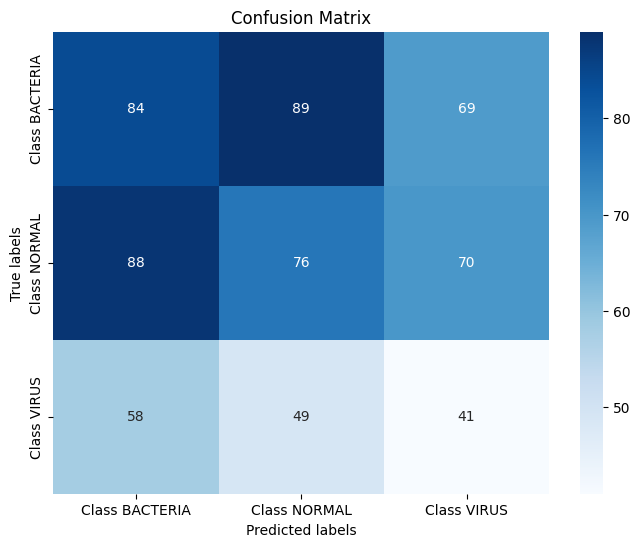

              precision    recall  f1-score   support

           0       0.37      0.35      0.36       242
           1       0.36      0.32      0.34       234
           2       0.23      0.28      0.25       148

    accuracy                           0.32       624
   macro avg       0.32      0.32      0.32       624
weighted avg       0.33      0.32      0.32       624



In [ ]:
y_true = multi_test_generator.labels
y_pred_probabilities = multi_model.predict(multi_test_generator)
y_pred = y_pred_probabilities.argmax(axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class BACTERIA', 'Class NORMAL', 'Class VIRUS'], yticklabels=['Class BACTERIA', 'Class NORMAL', 'Class VIRUS'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

### New Image Classification Using Embedded Vector  

In [ ]:
# Extract embedding vectors for training data
multi_embedding_vectors_train = embedding_multi_model.predict(multi_train_generator)
multi_embedding_vectors_test = embedding_multi_model.predict(multi_test_generator)

multi_embedding_vectors_train_flat = multi_embedding_vectors_train.reshape(multi_embedding_vectors_train.shape[0], -1)
multi_embedding_vectors_test_flat = multi_embedding_vectors_test.reshape(multi_embedding_vectors_test.shape[0], -1)

#Find best n_neighbors value
#multi_best_n, multi_best_accuracy = find_best_n_neighbors(multi_embedding_vectors_train_flat, multi_train_generator.labels, multi_embedding_vectors_test_flat, multi_test_generator.labels)
#print('The best n_neighbors value is', multi_best_n, 'with an accuracy of', multi_best_accuracy)

39/39 [==============================] - 6s 147ms/step


In [ ]:
# Use KNN for classification
knn_classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
knn_classifier.fit(multi_embedding_vectors_train_flat, multi_train_generator.labels)

KNeighborsClassifier(n_neighbors=25)

In [ ]:
# Saving the embedding vectors for training and testing data to Google Drive
np.save('/content/drive/MyDrive/my_models/basics_in_deep_learning/my_embedding_vectors/multi_EV_train_part1.npy', multi_embedding_vectors_train_flat)
np.save('/content/drive/MyDrive/my_models/basics_in_deep_learning/my_embedding_vectors/multi_EV_test_part1.npy', multi_embedding_vectors_test_flat)

# Saving the labels to a file
multi_train_labels = multi_train_generator.classes
np.save('/content/drive/MyDrive/my_models/basics_in_deep_learning/my_labels/multi_train_labels_part1.npy', multi_train_labels)

multi_test_labels = multi_test_generator.classes
np.save('/content/drive/MyDrive/my_models/basics_in_deep_learning/my_labels/multi_test_labels_part1.npy', multi_test_labels)

In [ ]:
# Example of classifying a new image
multi_new_image_path = '/content/IM-0001-0001.jpeg'
multi_new_image = cv.imread(multi_new_image_path)
multi_new_image = cv.resize(multi_new_image, (IMG_HEIGHT, IMG_WIDTH))
multi_new_image = multi_new_image.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3) / 255.0

In [ ]:
# Extract the embedding vector for the new image
multi_embedding_vector_new = embedding_multi_model.predict(multi_new_image)
multi_embedding_vector_new_flat = multi_embedding_vector_new.reshape(multi_embedding_vector_new.shape[0], -1)

# Classify the new image using KNN
multi_predicted_class = knn_classifier.predict(multi_embedding_vector_new_flat)
if multi_predicted_class == 0:
  print(f"Predicted class for the new image is bacteria.")
elif multi_predicted_class == 1:
  print(f"Predicted class for the new image is normal.")
else:
  print(f"Predicted class for the new image is virus.")

1/1 [==============================] - 1s 866ms/step
Predicted class for the new image is virus.


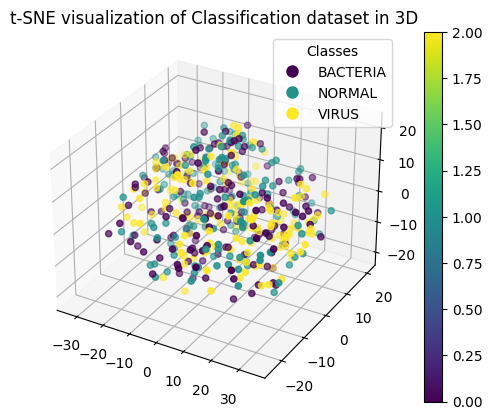

In [ ]:
# Use t-SNE with 3 components for 3D visualization
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(multi_embedding_vectors_train_flat)

labels = multi_train_generator.labels

# Subset of data points
subset_indices = np.random.choice(len(tsne_result), size=500, replace=False)

# Create a 3D scatter plot using the selected subset of data points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(xs=tsne_result[subset_indices, 0], ys=tsne_result[subset_indices, 1],
                     zs=tsne_result[subset_indices, 2], c=labels[subset_indices], cmap='viridis')

# Add color bar
cbar = plt.colorbar(scatter)

# Create legend
classes = list(set(labels))
class_names = {
    0: 'BACTERIA',
    1: 'NORMAL',
    2: 'VIRUS'
}

legend_labels = []
for cls in classes:
    legend_labels.append(plt.Line2D([0], [0], marker='o', color='w', label=class_names[cls],
                                    markerfacecolor=scatter.to_rgba(cls), markersize=10))

plt.legend(handles=legend_labels, title='Classes', loc='upper right')
plt.title("t-SNE visualization of Classification dataset in 3D")
plt.show()